# Multi Classification Problem

### 뉴스 기사 분류

이 절에서 로이터 뉴스를 46개의 서로 다른 토픽으로 분류하는 신경망을 만들어 보자. 클래스가 많기 때문에 이 문제는 다중 분류의 예이다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 정확히 말하면 **단일 레이블 다중 분류 문제**이다. 

## 로이터 데이터셋

1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


IMDB 데이터셋에서처럼 num_words=10000 매개변수는 데이터에서 **등장하는 단어 10,000개**로 제한합니다.

여기에는 8,982개의 훈련 샘플과 2,246개의 테스트 샘플이 있습니다:

In [2]:
print(len(train_data),len(test_data))

8982 2246


IMDB 리뷰처럼 각 샘플은 정수 리스트입니다(단어 인덱스):

In [3]:
print(train_data[10],sep=' ')

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


샘플에 연결된 레이블은 토픽의 인덱스는 0과 45 사이의 정수이다.

In [4]:
train_labels[10]

3

## 데이터 준비

이전의 예제와 동일한 코드를 사용해서 데이터를 벡터로 변환합니다:

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)

# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지입니다. 
1. 레이블의 리스트를 정수 텐서로 변환하는 것
2. **원-핫 인코딩**을 사용한다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고 한다. 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 그 외 나머지는 모두 0인 벡터이다.

In [6]:
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## 모델 구성

이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷하다. 두 경우 모두 짧은 텍스트를 분류하는 것이다. 여기서 새로운 사항이 생겼다. 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌습니다.

이전에 사용했던 것처럼 `Dense` 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많아 보인다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 **병목 지점**처럼 동작할 수 있으므로 규모가 큰 층을 사용해야 한다.

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


이 구조에서 주목해야 할 점이 두 가지 있습니다:

* **마지막 `Dense` 층의 크기가 46**입니다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻입니다. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩한 것이다.
* 마지막 층에 `softmax` 활성화 함수가 사용되었다. MNIST 예제에서 이런 방식을 보았다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력한다. 즉, 46차원의 출력 벡터를 만들고 `output[i]`는 어떤 샘플이 클래스 `i`에 속할 확률입니다. 46개의 값을 모두 더하면 1이 된다.

이런 문제에 사용할 최선의 손실 함수는 **`categorical_crossentropy`**이다. 이 함수는 두 확률 분포의 사이의 거리를 측정한다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리로 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다.

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 훈련 검증


In [9]:
y_train = train_labels
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85) 

이제 20번의 에포크로 모델을 훈련하자.

In [10]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 1s 180us/step - loss: 2.7685 - accuracy: 0.5077 - val_loss: 1.8954 - val_accuracy: 0.6395
Epoch 2/20
7634/7634 [==============================] - 1s 173us/step - loss: 1.5266 - accuracy: 0.6954 - val_loss: 1.4032 - val_accuracy: 0.7062
Epoch 3/20
7634/7634 [==============================] - 1s 186us/step - loss: 1.1246 - accuracy: 0.7685 - val_loss: 1.2077 - val_accuracy: 0.7292
Epoch 4/20
7634/7634 [==============================] - 1s 169us/step - loss: 0.8870 - accuracy: 0.8131 - val_loss: 1.0947 - val_accuracy: 0.7559
Epoch 5/20
7634/7634 [==============================] - 1s 162us/step - loss: 0.7081 - accuracy: 0.8516 - val_loss: 1.0220 - val_accuracy: 0.7737
Epoch 6/20
7634/7634 [==============================] - 1s 162us/step - loss: 0.5698 - accuracy: 0.8839 - val_loss: 0.9709 - val_accuracy: 0.7819
Epoch 7/20
7634/7634 [======

손실과 정확도 곡선을 살펴보자.

In [11]:
import matplotlib.pyplot as plt

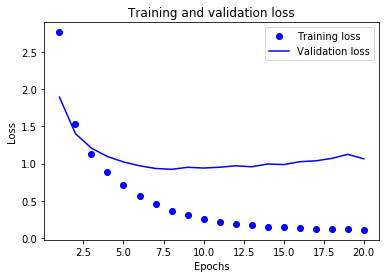

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

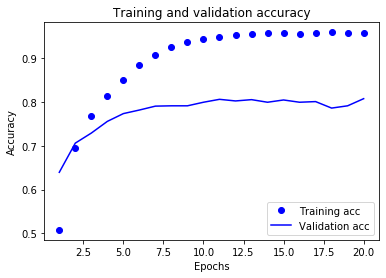

In [13]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 3번째 epochs 이후에 과대적합이 시작된다. 3번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가해보자.

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val))
results = model.evaluate(x_test, test_labels)

Train on 7634 samples, validate on 1348 samples
Epoch 1/3
7634/7634 [==============================] - 1s 190us/step - loss: 2.7118 - accuracy: 0.4781 - val_loss: 1.7834 - val_accuracy: 0.6395
Epoch 2/3
7634/7634 [==============================] - 1s 172us/step - loss: 1.4450 - accuracy: 0.6956 - val_loss: 1.3467 - val_accuracy: 0.6973
Epoch 3/3
2246/2246 [==============================] - 1s 224us/step


In [15]:
results

[1.2055838347967458, 0.7359750866889954]

대략 73.5%의 정확도를 달성했다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성한다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 13.5% 정도를 달성할 수 있다. 

In [17]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

44.36420302760463

## 새로운 데이터에 대해 예측하기

모델 인스턴스의 `predict` 메서드는 46개 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다:

In [18]:
predictions = model.predict(x_test)

`predictions`의 각 항목은 길이가 46인 벡터입니다:

In [19]:
predictions[0].shape

(46,)

이 벡터의 원소 합은 1입니다:

In [20]:
np.sum(predictions[0])

1.0

가장 큰 값이 예측 클래스가 됩니다. 즉, 가장 확률이 높은 클래스입니다:

In [21]:
np.argmax(predictions[0])

4

## 레이블과 손실을 다루는 다른 방법

앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다:

In [22]:
#y_train = np.array(train_labels)
#y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. 코드 3-21에 사용된 손실 함수 `categorical_crossentropy`는 레이블이 범주형 인코딩되어 있을 것이라고 기대합니다. 정수 레이블을 사용할 때는 `sparse_categorical_crossentropy`를 사용해야 합니다:

In [23]:
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 `categorical_crossentropy`와 동일합니다.

## 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 된다. 46차원보다 훨씬 작은 중간층을 두면 정보의 병목현상을 보자.

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 2s 286us/step - loss: 2.7713 - accuracy: 0.4361 - val_loss: 1.9825 - val_accuracy: 0.6165
Epoch 2/20
7634/7634 [==============================] - 2s 271us/step - loss: 1.6546 - accuracy: 0.6365 - val_loss: 1.5590 - val_accuracy: 0.6461
Epoch 3/20
7634/7634 [==============================] - 2s 276us/step - loss: 1.3394 - accuracy: 0.6861 - val_loss: 1.4311 - val_accuracy: 0.6662
Epoch 4/20
7634/7634 [==============================] - 2s 270us/step - loss: 1.1648 - accuracy: 0.7193 - val_loss: 1.3960 - val_accuracy: 0.6691
Epoch 5/20
7634/7634 [==============================] - 2s 276us/step - loss: 1.0371 - accuracy: 0.7429 - val_loss: 1.3418 - val_accuracy: 0.6847
Epoch 6/20
7634/7634 [==============================] - 2s 280us/step - loss: 0.9347 - accuracy: 0.7587 - val_loss: 1.3468 - val_accuracy: 0.6847
Epoch 7/20
7634/7634 [==============================] - 2s 279us/step - loss

검증 정확도의 최고 값은 약 70.7%로 0.8% 정도 감소되었다. 이런 손실의 대부분 원인은 많은 정보(46개 클래스의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문이다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했다.

## 추가 실험

* 더 크거나 작은 층을 사용해 보세요: 32개 유닛, 128개 유닛 등
* 여기에서 두 개의 은닉층을 사용했습니다. 한 개의 은닉층이나 세 개의 은닉층을 사용해 보세요.

In [26]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val))
results = model.evaluate(x_test, test_labels)
print(results)

Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 3s 393us/step - loss: 1.5430 - accuracy: 0.6520 - val_loss: 1.2101 - val_accuracy: 0.7233
Epoch 2/20
7634/7634 [==============================] - 3s 369us/step - loss: 0.8269 - accuracy: 0.8161 - val_loss: 1.0179 - val_accuracy: 0.7619
Epoch 3/20
7634/7634 [==============================] - 3s 378us/step - loss: 0.5098 - accuracy: 0.8826 - val_loss: 0.9649 - val_accuracy: 0.7945
Epoch 4/20
7634/7634 [==============================] - 3s 378us/step - loss: 0.3303 - accuracy: 0.9266 - val_loss: 1.0617 - val_accuracy: 0.7930
Epoch 5/20
7634/7634 [==============================] - 3s 367us/step - loss: 0.2417 - accuracy: 0.9442 - val_loss: 1.1464 - val_accuracy: 0.7774
Epoch 6/20
7634/7634 [==============================] - 3s 371us/step - loss: 0.1966 - accuracy: 0.9527 - val_loss: 1.1051 - val_accuracy: 0.8064
Epoch 7/20
7634/7634 [==============================] - 3s 375us/step - loss

#### 하나의 층이 추가되었더니 정확도가 약 77.6% 까지 올라갔다.

## 정리

다음은 이 예제에서 배운 것들입니다.

* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 `Dense` 층의 크기는 **N**이어야 합니다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 **`softmax`** 활성화 함수를 사용해야 합니다.
* 이런 문제에는 항상 범주형 **크로스엔트로피**를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화합니다.
* 다중 분류에서 레이블을 다루는 **두 가지 방법**이 있습니다.

    * 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 `categorical_crossentropy` 손실 함수를 사용합니다.
    * 레이블을 정수로 인코딩하고 `sparse_categorical_crossentropy` 손실 함수를 사용합니다.
    
* 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 **정보의 병목**이 생기지 않도록 해야 합니다.